In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector as SFS, SelectFromModel
from xgboost import XGBClassifier as XGBC

In [74]:
merged=pd.read_csv('merged.csv')
mergedT=pd.read_csv('mergedTest.csv')

In [75]:
cla_merged=merged.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','icu_outcome','los_icu'], axis=1)
cla_mergedT=mergedT.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','icu_outcome','los_icu'],axis=1)


In [76]:
#split X, y

X_train=cla_merged.drop(['icu_death'], axis=1)
y_train=cla_merged['icu_death']

X_test=cla_mergedT.drop(['icu_death'], axis=1)
y_test=cla_mergedT['icu_death']

In [77]:
#normalise
num_cols = X_train.columns[X_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = preprocessing.StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

num_cols = X_test.columns[X_test.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = preprocessing.StandardScaler()
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

# Feature importance

In [78]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [79]:
rank = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

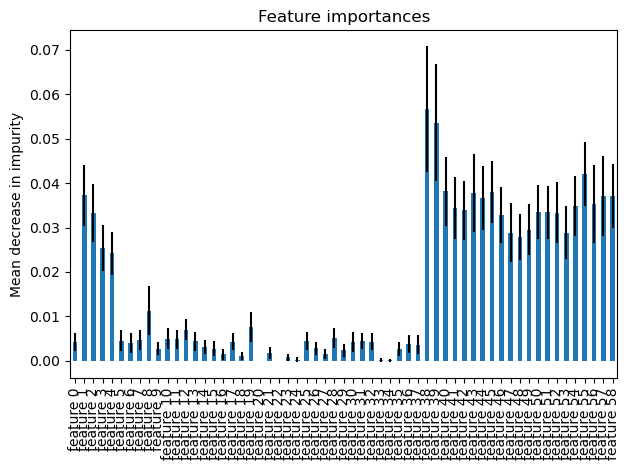

In [80]:

feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
rfc_importances = pd.Series(rank, index=feature_names)

fig, ax = plt.subplots()
rfc_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [81]:
rank.mean()

0.016949152542372885

In [82]:
feats=[]
for i,v in enumerate(rank):
    if v>0.03:
        feats.append(X_train.columns[i])
        print('Feature: %0d, Score: %.5f' % (i,v))

print(feats)        
        


Feature: 1, Score: 0.03729
Feature: 2, Score: 0.03328
Feature: 38, Score: 0.05667
Feature: 39, Score: 0.05360
Feature: 40, Score: 0.03814
Feature: 41, Score: 0.03435
Feature: 42, Score: 0.03383
Feature: 43, Score: 0.03784
Feature: 44, Score: 0.03668
Feature: 45, Score: 0.03807
Feature: 46, Score: 0.03289
Feature: 50, Score: 0.03356
Feature: 51, Score: 0.03345
Feature: 52, Score: 0.03334
Feature: 54, Score: 0.03479
Feature: 55, Score: 0.04205
Feature: 56, Score: 0.03537
Feature: 57, Score: 0.03707
Feature: 58, Score: 0.03705
['admission_age', 'weight_admit', 'aniongap', 'bicarbonate', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium', 'mchc', 'mcv', 'platelet', 'rdw', 'wbc', 'inr', 'pt', 'ptt']


# select from model

In [83]:
sel = SelectFromModel(rfc)
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=0))

In [84]:
selected_feats=sel.get_feature_names_out()
print(selected_feats)
print(len(selected_feats))

['admission_age' 'weight_admit' 'height' 'charlson_score' 'aniongap'
 'bicarbonate' 'bun' 'calcium' 'chloride' 'creatinine' 'glucose' 'sodium'
 'potassium' 'hematocrit' 'hemoglobin' 'mch' 'mchc' 'mcv' 'platelet' 'rbc'
 'rdw' 'wbc' 'inr' 'pt' 'ptt']
25


# RF Classifier (select from model)

In [85]:
rfc = RandomForestClassifier(criterion='entropy')

parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
stratifiedCV = StratifiedKFold(n_splits=5)
Best_rfc = GridSearchCV(
    rfc,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV
)

Best_rfc.fit(X_train[selected_feats],y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [86]:
Best_rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9)

In [87]:
Best_rfc.best_score_

0.0778016167937814

In [88]:
#Test-RF with forward selected feature

rfc_pred = Best_rfc.predict(X_test[selected_feats])
rfc_pp=Best_rfc.predict_proba(X_test[selected_feats])

rfc_posProb = rfc_pp[:,-1]

rfc_f1 = f1_score(y_test,rfc_pred)
rfc_auroc = roc_auc_score(y_test, rfc_pp[:,-1])
print(rfc_f1)
print(rfc_auroc)
pd.crosstab(y_test, rfc_pred)

0.11235955056179775
0.7805696308719269


col_0,0,1
icu_death,,
0,3660,9
1,386,25


# RF Classifier (importance >0.3)

In [89]:
rfc = RandomForestClassifier(criterion='entropy')

parameters = {'max_depth':np.arange(start=1,stop=10,step=1)}
stratifiedCV = StratifiedKFold(n_splits=5)
Best_rfc = GridSearchCV(
    rfc,
    param_grid=parameters,
    scoring='f1',
    cv=stratifiedCV
)

Best_rfc.fit(X_train[feats],y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [90]:
Best_rfc.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=9)

In [91]:
Best_rfc.best_score_

0.0894395453241684

In [92]:
#Test-RF with forward selected feature

rfc_pred = Best_rfc.predict(X_test[feats])
rfc_pp=Best_rfc.predict_proba(X_test[feats])

rfc_posProb = rfc_pp[:,-1]

rfc_f1 = f1_score(y_test,rfc_pred)
rfc_auroc = roc_auc_score(y_test, rfc_pp[:,-1])
print(rfc_f1)
print(rfc_auroc)
pd.crosstab(y_test, rfc_pred)

0.13303769401330376
0.7737080384811524


col_0,0,1
icu_death,,
0,3659,10
1,381,30


# RF Regression-select frm model

In [93]:
reg_merged=merged.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','icu_outcome'], axis=1)
reg_mergedT=mergedT.drop(['id','hosp_admittime','hosp_dischtime','icu_intime','icu_outtime','icu_outcome'],axis=1)

In [94]:
#split X, y

regX_train=reg_merged.drop(['los_icu'], axis=1)
regy_train=reg_merged['los_icu']

regX_test=reg_mergedT.drop(['los_icu'], axis=1)
regy_test=reg_mergedT['los_icu']

In [95]:
#normalise
num_cols = regX_train.columns[regX_train.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = preprocessing.StandardScaler()
regX_train[num_cols] = scaler.fit_transform(regX_train[num_cols])

num_cols = regX_test.columns[regX_test.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
scaler = preprocessing.StandardScaler()
regX_test[num_cols] = scaler.fit_transform(regX_test[num_cols])

In [96]:
#select frm model

sel = SelectFromModel(RandomForestRegressor())
sel.fit(regX_train, regy_train)

selected_feats=sel.get_feature_names_out()
print(selected_feats)
print(len(selected_feats))

['admission_age' 'weight_admit' 'height' 'charlson_score' 'aniongap'
 'bicarbonate' 'bun' 'calcium' 'chloride' 'creatinine' 'glucose' 'sodium'
 'potassium' 'hematocrit' 'hemoglobin' 'mch' 'mchc' 'mcv' 'platelet' 'rbc'
 'rdw' 'wbc' 'inr' 'pt' 'ptt']
25


In [99]:
rfr = RandomForestRegressor()

parameters = {'max_depth':np.arange(start=1,stop=10,step=1),
             'n_estimators':np.arange(start=100,stop=500,step=100),
             }
KfoldCV = KFold(n_splits=5, shuffle =True, random_state=1)
Best_rfr = GridSearchCV(
    rfr,
    param_grid=parameters,
    cv=KfoldCV,
)

Best_rfr.fit(regX_train[selected_feats],regy_train)


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([100, 200, 300, 400])})

In [100]:
Best_rfr.best_estimator_

RandomForestRegressor(max_depth=2, n_estimators=200)

In [102]:
rfr_pred = Best_rfr.predict(regX_test[selected_feats])
rfr_r2 = r2_score(regy_test, rfr_pred)

rfr_r2

0.061604286180132695